In [1]:
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [2]:
plt.rc('figure', figsize=(14,8))
plt.rc('font', size=16)

In [3]:
df = wrangle_311(spark)
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments
-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime      

In [4]:
df.dtypes

[('case_id', 'int'),
 ('case_opened_date', 'timestamp'),
 ('case_closed_date', 'timestamp'),
 ('case_due_date', 'timestamp'),
 ('case_late', 'boolean'),
 ('num_days_late', 'double'),
 ('case_closed', 'boolean'),
 ('service_request_type', 'string'),
 ('SLA_days', 'double'),
 ('case_status', 'string'),
 ('source_id', 'string'),
 ('request_address', 'string'),
 ('council_district', 'string'),
 ('num_weeks_late', 'double'),
 ('zipcode', 'string'),
 ('case_age', 'int'),
 ('days_to_closed', 'int'),
 ('case_lifetime', 'int'),
 ('department', 'string'),
 ('dept_subject_to_SLA', 'boolean')]

In [5]:
df.groupBy('dept_subject_to_SLA').count().show()

+-------------------+------+
|dept_subject_to_SLA| count|
+-------------------+------+
|               true|841671|
|              false|    33|
+-------------------+------+



In [6]:
df = df.drop('dept_subject_to_SLA', 'days_to_closed', 'case_closed',
             'case_id', 'source_id', 'request_address', 'zipcode',
             'case_due_date')

In [7]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 case_age             | 219                  
 case_lifetime        | 0                    
 department           | Animal Care Services 
only showing top 1 row



Text(0.5, 0, 'Number of Cases')

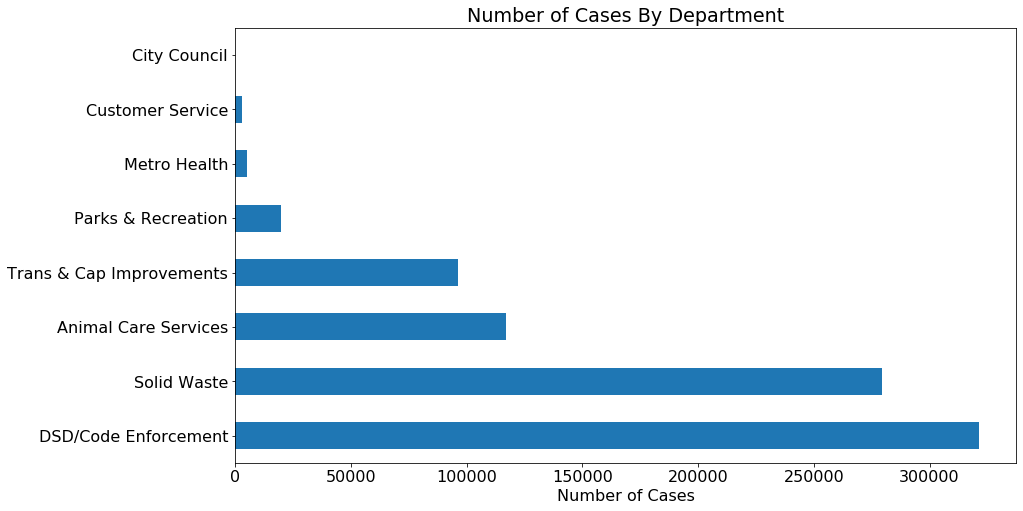

In [8]:
df.groupBy('department').count().toPandas().set_index('department')\
['count'].sort_values(ascending=False).plot.barh()

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

In [9]:
df.where('case_late').groupBy('department').count().show()

+--------------------+-----+
|          department|count|
+--------------------+-----+
|         Solid Waste|32945|
|Animal Care Services|23276|
|Trans & Cap Impro...| 5411|
|  Parks & Recreation| 3797|
|    Customer Service| 2010|
|        Metro Health|  829|
|DSD/Code Enforcement|26235|
+--------------------+-----+



In [10]:
dept_cases = df.groupBy('department').count()\
                .withColumnRenamed('count', 'num_cases')
dept_cases.show()

+--------------------+---------+
|          department|num_cases|
+--------------------+---------+
|         Solid Waste|   279270|
|Animal Care Services|   116915|
|Trans & Cap Impro...|    96193|
|  Parks & Recreation|    19907|
|    Customer Service|     2849|
|        Metro Health|     5163|
|        City Council|       33|
|DSD/Code Enforcement|   321374|
+--------------------+---------+



In [11]:
dept_late_cases = df.where('case_late').groupBy('department').count()\
.withColumnRenamed('count', 'late_cases')\
.join(dept_cases, 'department', 'left')\
.withColumn('percent_late', col('late_cases') / col('num_cases'))\
.sort(col('percent_late').desc())
dept_late_cases.show()

+--------------------+----------+---------+-------------------+
|          department|late_cases|num_cases|       percent_late|
+--------------------+----------+---------+-------------------+
|    Customer Service|      2010|     2849| 0.7055107055107055|
|Animal Care Services|     23276|   116915|0.19908480520035923|
|  Parks & Recreation|      3797|    19907|0.19073692670919776|
|        Metro Health|       829|     5163|0.16056556265736974|
|         Solid Waste|     32945|   279270| 0.1179682744297633|
|DSD/Code Enforcement|     26235|   321374| 0.0816338596152769|
|Trans & Cap Impro...|      5411|    96193|0.05625149439148379|
+--------------------+----------+---------+-------------------+



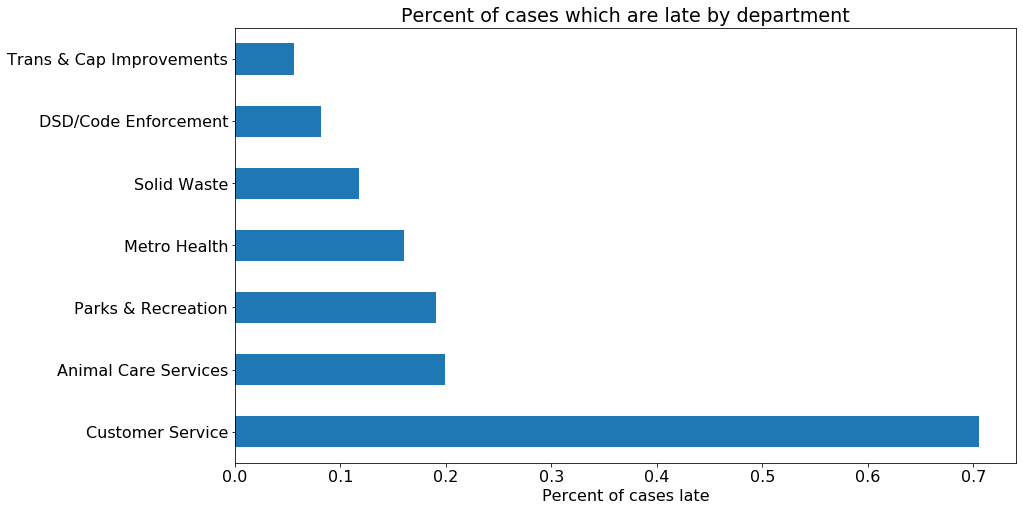

In [12]:
ax = dept_late_cases.select('department', 'percent_late')\
.toPandas().set_index('department').plot.barh()

plt.title('Percent of cases which are late by department')
ax.set_ylabel("")
ax.set_xlabel('Percent of cases late')
ax.get_legend().remove()

Text(0.5, 0, 'Average days late')

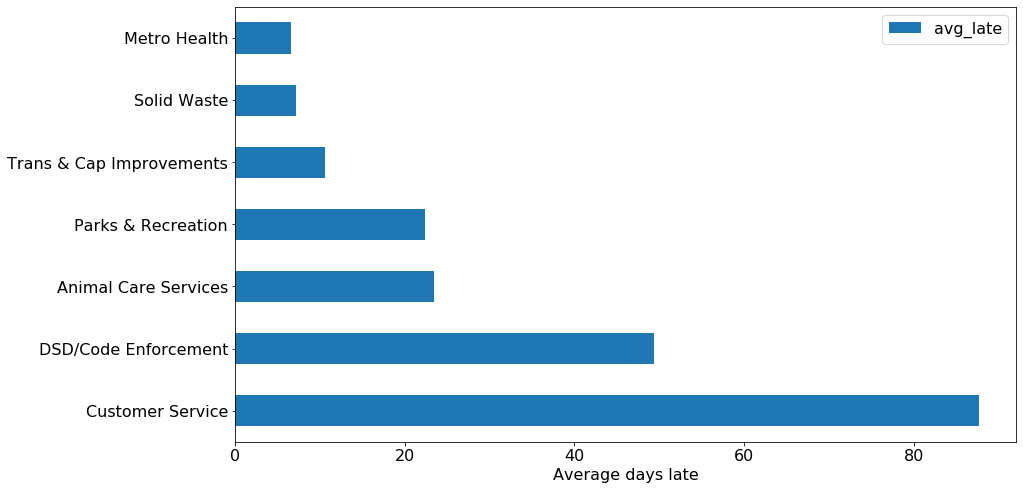

In [13]:
ax = df.where('case_late').groupBy('department')\
.agg(avg('num_days_late').alias('avg_late'))\
.sort(col('avg_late').desc()).toPandas()\
.set_index('department').plot.barh()

ax.set_ylabel('')
ax.set_xlabel('Average days late')

In [14]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 case_age             | 219                  
 case_lifetime        | 0                    
 department           | Animal Care Services 
only showing top 1 row



In [15]:
df.where('case_late').groupBy('service_request_type')\
.agg(max('num_days_late').alias('max_late'))\
.sort(col('max_late').desc()).first()

Row(service_request_type='Bandit Signs', max_late=519.6980787)

In [16]:
df.where('case_late').where(df.department == 'Parks & Recreation')\
.groupBy('service_request_type')\
.agg(max('num_days_late').alias('max_late'))\
.sort(col('max_late').desc()).first()

Row(service_request_type='Painting', max_late=427.6660069)

In [17]:
df.where(df.department == 'DSD/Code Enforcement')\
.groupBy('service_request_type').count()\
.sort(col('count').desc()).show(5, truncate=False)

+--------------------------------+-----+
|service_request_type            |count|
+--------------------------------+-----+
|Overgrown Yard/Trash            |65895|
|Bandit Signs                    |32910|
|Front Or Side Yard Parking      |28794|
|Junk Vehicle On Private Property|21473|
|Alley-Way Maintenance           |20214|
+--------------------------------+-----+
only showing top 5 rows



In [18]:
df.where(df.department == 'Metro Health')\
.groupBy('service_request_type').count()\
.sort(col('count').desc()).show(5, truncate=False)

+-----------------------+-----+
|service_request_type   |count|
+-----------------------+-----+
|License Renewal Invoice|1349 |
|Hygienic Practices     |946  |
|Pests                  |715  |
|Food Contact Surfaces  |602  |
|Public Right of Way    |538  |
+-----------------------+-----+
only showing top 5 rows



In [19]:
df.where(df.department == 'Trans & Cap Improvements')\
.groupBy('service_request_type').count()\
.sort(col('count').desc()).show(5, truncate=False)

+----------------------------------------------+-----+
|service_request_type                          |count|
+----------------------------------------------+-----+
|Pot Hole Repair                               |20616|
|Traffic Signal Ops and Maintenance - Emergency|7997 |
|Traffic Sign Missing/Down                     |5674 |
|Base/Pavement Repair                          |5385 |
|Signal Timing Modification                    |4414 |
+----------------------------------------------+-----+
only showing top 5 rows



In [20]:
df.groupBy('department').count().show(truncate=False)

+------------------------+------+
|department              |count |
+------------------------+------+
|Solid Waste             |279270|
|Animal Care Services    |116915|
|Trans & Cap Improvements|96193 |
|Parks & Recreation      |19907 |
|Customer Service        |2849  |
|Metro Health            |5163  |
|City Council            |33    |
|DSD/Code Enforcement    |321374|
+------------------------+------+



In [21]:
cases_by_day = df.select("department",
    date_format("case_opened_date", "yyyy-MM-dd")\
        .alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd")\
        .alias("case_closed_date"),)
cases_by_day.show(5)

+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
|DSD/Code Enforcement|      2018-01-01|      2018-01-02|
|Animal Care Services|      2018-01-01|      2018-01-01|
+--------------------+----------------+----------------+
only showing top 5 rows



In [22]:
cases_by_day.count()

841704

In [23]:
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda 
            df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')['count']
)
cases_opened_by_day.name = 'cases_opened'

In [24]:
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count().na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda 
            df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')['count']
)
cases_closed_by_day.name = 'cases_closed'

In [25]:
ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)
ts.head(5)

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1397,385
2017-01-03,1760,734
2017-01-04,1613,1206
2017-01-05,1791,1173


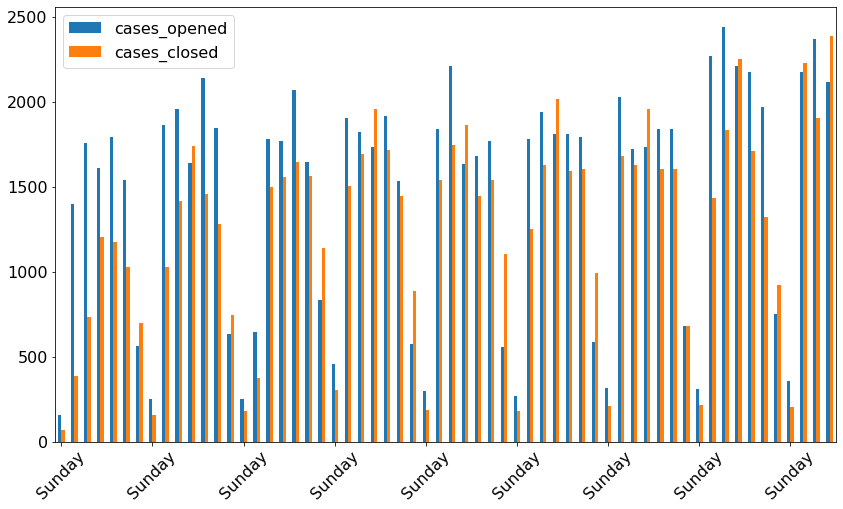

In [26]:
ax = ts[:60].plot.bar()
ax.set_xticks(7*np.arange(9))
ax.set_xticklabels(('Sunday '*9).split(), rotation=45)
plt.show()

In [27]:
cases_by_day.where(col('department') == 'Customer Service')\
.groupBy('case_opened_date').count()\
.sort(col('case_opened_date')).show(10)

+----------------+-----+
|case_opened_date|count|
+----------------+-----+
|      2017-01-02|    3|
|      2017-01-03|    6|
|      2017-01-04|    2|
|      2017-01-05|    5|
|      2017-01-06|    3|
|      2017-01-07|    2|
|      2017-01-09|    2|
|      2017-01-10|    5|
|      2017-01-11|    3|
|      2017-01-12|    4|
+----------------+-----+
only showing top 10 rows



In [28]:
cases_by_day.where(col('department') == 'Customer Service')\
.groupBy('case_opened_date').count()\
.sort(col('case_opened_date')).agg(avg(col('count'))).show()

+-----------+
| avg(count)|
+-----------+
|5.564453125|
+-----------+



In [29]:
cases_by_day.where(col('department') == 'Solid Waste')\
.groupBy(dayofweek('case_opened_date').alias('weekday'))\
.count().sort(col('weekday')).show()

+-------+-----+
|weekday|count|
+-------+-----+
|   null|    3|
|      1| 6882|
|      2|58085|
|      3|58120|
|      4|41947|
|      5|47718|
|      6|51203|
|      7|15312|
+-------+-----+



In [30]:
df.where(col('department') == 'Solid Waste')\
.groupBy(dayofweek('case_opened_date').alias('weekday'))\
.count().sort(col('weekday')).show()

+-------+-----+
|weekday|count|
+-------+-----+
|   null|    3|
|      1| 6882|
|      2|58085|
|      3|58120|
|      4|41947|
|      5|47718|
|      6|51203|
|      7|15312|
+-------+-----+



In [31]:
df.groupBy(month('case_opened_date')).count().show()

+-----------------------+------+
|month(case_opened_date)| count|
+-----------------------+------+
|                     12| 34327|
|                   null|    16|
|                      1| 82691|
|                      6| 89580|
|                      3|100696|
|                      5| 94492|
|                      9| 43179|
|                      4| 89345|
|                      8| 57941|
|                      7| 85476|
|                     10| 43908|
|                     11| 38047|
|                      2| 82006|
+-----------------------+------+



In [32]:
df.where(dayofweek('case_opened_date').isNull())\
.groupBy('department','service_request_type', ).count()\
.sort(col('department')).show(truncate=False)

+------------------------+--------------------------------+-----+
|department              |service_request_type            |count|
+------------------------+--------------------------------+-----+
|Animal Care Services    |Stray Animal                    |2    |
|Animal Care Services    |Officer Standby                 |1    |
|DSD/Code Enforcement    |Junk Vehicle On Private Property|1    |
|DSD/Code Enforcement    |Overgrown Yard/Trash            |2    |
|DSD/Code Enforcement    |Graffiti Public Property        |2    |
|DSD/Code Enforcement    |Vacant Lot/Overgrown/Trash      |1    |
|Solid Waste             |Dead Animal - Cat               |2    |
|Solid Waste             |Dead Animal - Misc              |1    |
|Trans & Cap Improvements|Traffic Sign Missing/Down       |1    |
|Trans & Cap Improvements|Pot Hole Repair                 |3    |
+------------------------+--------------------------------+-----+

